# Packet Analysis - Final Project

In [1]:
from scapy.all import * # Packet manipulation
import pandas as pd # Pandas - Create and Manipulate DataFrames
import numpy as np # Math Stuff (don't worry only used for one line :] )
import binascii # Binary to Ascii 
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline



# Read input pcap to current stream

In [2]:
# rdpcap used to Read Pcap

pcap = rdpcap("capture.pcap")
#pcap = rdpcap("botnet-capture-20110810-neris.pcap")

In [3]:
pcap

<capture.pcap: TCP:0 UDP:62 ICMP:0 Other:0>

# TCP Segment 

In [4]:
print()

()


# Exploring an item in packet list

In [5]:
# ETHERNET -> Internet Protocol -> Layer 4 Segments
##  parse IP layer and the TCP,UDP  payload

# Retrieving only one packet from pcap file
ethernet_frame = pcap[0]
ip_packet = ethernet_frame.payload
segment = ip_packet.payload
data = segment.payload # Retrieve payload that comes after layer 4


print(ethernet_frame.summary())
print("IP_packet",ip_packet.summary())
print("segment",segment.summary())
print("data",data.summary()) 

# Complete picture of a packet
## It has complete picture of etheret frame and IP, UDP, DNS info of the packets
ethernet_frame.show()

Ether / IP / UDP / DNS Qry "google.com."  / Raw
('IP_packet', 'IP / UDP / DNS Qry "google.com."  / Raw')
('segment', 'UDP / DNS Qry "google.com."  / Raw')
('data', 'DNS Qry "google.com."  / Raw')
###[ Ethernet ]### 
  dst       = 80:37:73:96:9b:db
  src       = 88:e9:fe:6a:92:52
  type      = 0x800
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 961
     id        = 1
     flags     = 
     frag      = 0
     ttl       = 64
     proto     = udp
     chksum    = 0x52e6
     src       = 10.1.10.53
     dst       = 84.54.22.33
     \options   \
###[ UDP ]### 
        sport     = domain
        dport     = domain
        len       = 941
        chksum    = 0xf60e
###[ DNS ]### 
           id        = 12
           qr        = 0
           opcode    = QUERY
           aa        = 0
           tc        = 0
           rd        = 1
           ra        = 0
           z         = 0
           ad        = 0
           cd        = 0
           rcode    

### With the help of Scapy object importing layers

In [6]:
# Review of the object types in scapy
print(type(ethernet_frame))
print(type(ip_packet))
print(type(segment))

# Packets can be filtered on layers 
ethernet_type = type(ethernet_frame)
ip_type = type(ip_packet)
tcp_type = type(segment)
print("Ethernet",pcap[ethernet_type])
print("IP", pcap[ip_type])
print("TCP", pcap[tcp_type])


from scapy.layers.l2 import Ether
from scapy.layers.inet import IP
from scapy.layers.inet import TCP, UDP

print("UDP", pcap[UDP])


<class 'scapy.layers.l2.Ether'>
<class 'scapy.layers.inet.IP'>
<class 'scapy.layers.inet.UDP'>
('Ethernet', <Ether from capture.pcap: TCP:0 UDP:62 ICMP:0 Other:0>)
('IP', <IP from capture.pcap: TCP:0 UDP:62 ICMP:0 Other:0>)
('TCP', <UDP from capture.pcap: TCP:0 UDP:62 ICMP:0 Other:0>)
('UDP', <UDP from capture.pcap: TCP:0 UDP:62 ICMP:0 Other:0>)


# Obtaining Dataframe from PCAP

In [7]:
# Collect field names from IP/TCP/UDP (These will be columns in DF)
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Create a DataFrame
df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    # Field array for each row of DataFrame
    field_values = []
    # Add all IP fields to dataframe
    for field in ip_fields:
        if field == 'options':
            # Retrieving number of options defined in IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Appending payload to examine later
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Adding row to DataFrame
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)


df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")
df

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,          googlecom    �PNG\r\n\n   \rIH...,000c0100000100000000000006676f6f676c6503636f6d...
1,4,5,32,84,58919,,0,122,17,13836,...,None,None,None,None,65061,None,None,56,  ��      googlecom    �      + &��@...,000c8180000100010000000006676f6f676c6503636f6d...
2,4,5,0,975,1,,0,64,17,21208,...,None,None,None,None,36378,None,None,947,          googlecom    :�le:ǩ��� ���:|�X...,000c0100000100000000000006676f6f676c6503636f6d...
3,4,5,32,84,59493,,0,122,17,13262,...,None,None,None,None,65063,None,None,56,  ��      googlecom    �      ) &��@...,000c8180000100010000000006676f6f676c6503636f6d...
4,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,          googlecom    ��^n�''���$�����R�...,000c0100000100000000000006676f6f676c6503636f6d...
5,4,5,32,84,59660,,0,122,17,13095,...,None,None,None,None,65064,None,None,56,  ��      googlecom    �      ( &��@...,000c8180000100010000000006676f6f676c6503636f6d...
6,4,5,0,998,1,,0,64,17,21185,...,None,None,None,None,65315,None,None,970,          googlecom    䎑Bj_�a\r�����DJ�...,000c0100000100000000000006676f6f676c6503636f6d...
7,4,5,32,84,60495,,0,122,17,12260,...,None,None,None,None,65065,None,None,56,  ��      googlecom    �      ' &��@...,000c8180000100010000000006676f6f676c6503636f6d...
8,4,5,0,1003,1,,0,64,17,21180,...,None,None,None,None,38088,None,None,975,          googlecom    ���˴���rj�GBWO��...,000c0100000100000000000006676f6f676c6503636f6d...
9,4,5,32,84,60889,,0,122,17,11866,...,None,None,None,None,65066,None,None,56,  ��      googlecom    �      & &��@...,000c8180000100010000000006676f6f676c6503636f6d...


### DataFrame information

In [8]:
# Retrieve first row from DataFrame
print("First row",df.iloc[0])

print("Shape",df.shape)

# Return first 5 rows

print("head",df.head())
# Return last 5 rows

print("tail",df.tail())
# Return the Source Address for all rows
print("source",df['src'])

# Return Src Address, Dst Address, Src Port, Dst Port
df[['src','dst','sport','dport']]

('First row', version                                                        4
ihl                                                            5
tos                                                            0
len                                                          961
id                                                             1
flags                                                           
frag                                                           0
ttl                                                           64
proto                                                         17
chksum                                                     21222
src                                                   10.1.10.53
dst                                                  84.54.22.33
options                                                        0
time                                                  1.5322e+09
sport                                                         53
dport      

,src,dst,sport,dport
0,10.1.10.53,84.54.22.33,53,53
1,84.54.22.33,10.1.10.53,53,53
2,10.1.10.53,84.54.22.33,53,53
3,84.54.22.33,10.1.10.53,53,53
4,10.1.10.53,84.54.22.33,53,53
5,84.54.22.33,10.1.10.53,53,53
6,10.1.10.53,84.54.22.33,53,53
7,84.54.22.33,10.1.10.53,53,53
8,10.1.10.53,84.54.22.33,53,53
9,84.54.22.33,10.1.10.53,53,53


# Statistics

In [9]:
# Top Source Adddress
print("# Top Source Address")
print(df['src'].describe(),'\n\n')

# Top Destination Address
print("# Top Destination Address")
print(df['dst'].describe(),"\n\n")

frequent_address = df['src'].describe()['top']

# Who is the top address speaking to
print("# Who is Top Address Speaking to?")
print(df[df['src'] == frequent_address]['dst'].unique(),"\n\n")

# Who is the top address speaking to (dst ports)
print("# Who is the top address speaking to (Destination Ports)")
print(df[df['src'] == frequent_address]['dport'].unique(),"\n\n")

# Who is the top address speaking to (src ports)
print("# Who is the top address speaking to (Source Ports)")
print(df[df['src'] == frequent_address]['sport'].unique(),"\n\n")

# Top Source Address
(count             62
unique             3
top       10.1.10.53
freq              31
Name: src, dtype: object, '\n\n')
# Top Destination Address
(count             62
unique             3
top       10.1.10.53
freq              31
Name: dst, dtype: object, '\n\n')
# Who is Top Address Speaking to?
(array(['84.54.22.33', '75.75.75.75'], dtype=object), '\n\n')
# Who is the top address speaking to (Destination Ports)
(array([53L], dtype=object), '\n\n')
# Who is the top address speaking to (Source Ports)
(array([53L, 15812L, 23903L], dtype=object), '\n\n')


In [10]:
# Unique Source Addresses
print("Unique Source Addresses")
print(df['src'].unique())

print()

# Unique Destination Addresses
print("Unique Destination Addresses")
print(df['dst'].unique())

Unique Source Addresses
['10.1.10.53' '84.54.22.33' '75.75.75.75']
()
Unique Destination Addresses
['84.54.22.33' '10.1.10.53' '75.75.75.75']


# Graphing

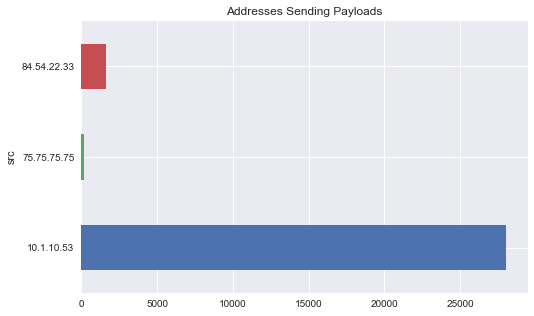

In [11]:
# Group by Source Address and Payload Sum
source_addresses = df.groupby("src")['payload'].sum()
source_addresses.plot(kind='barh',title="Addresses Sending Payloads",figsize=(8,5))

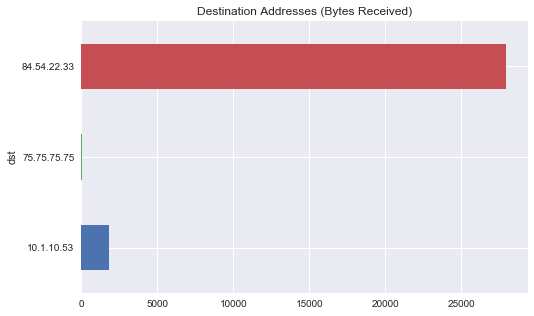

In [12]:
# Group by Destination Address and Payload Sum
destination_addresses = df.groupby("dst")['payload'].sum()
destination_addresses.plot(kind='barh', title="Destination Addresses (Bytes Received)",figsize=(8,5))

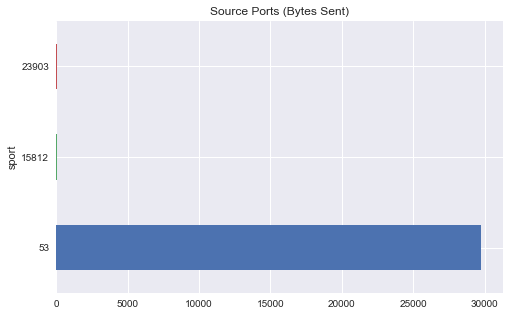

In [13]:
# Group by Source Port and Payload Sum
source_payloads = df.groupby("sport")['payload'].sum()
source_payloads.plot(kind='barh',title="Source Ports (Bytes Sent)",figsize=(8,5))

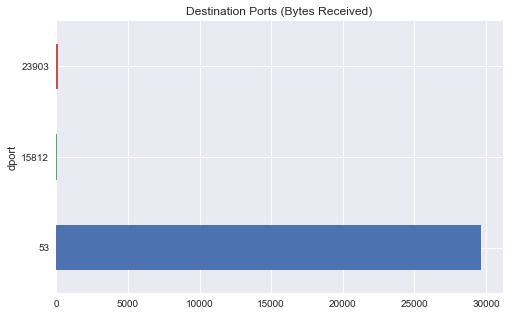

In [14]:
# Group by Destination Port and Payload Sum
destination_payloads = df.groupby("dport")['payload'].sum()
destination_payloads.plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))

Text(0.5,1,'History of bytes sent by most frequent address')

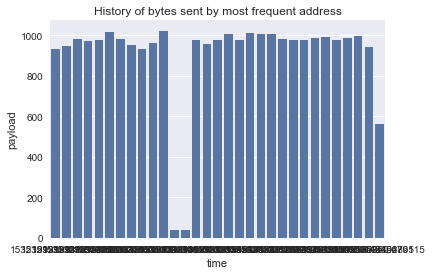

In [15]:
#groupby("time")['payload'].sum().plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))

frequent_address_df = df[df['src'] == frequent_address]
x = frequent_address_df['payload'].tolist()
sns.barplot(x="time", y="payload", data=frequent_address_df[['payload','time']],
            label="Total", color="b").set_title("History of bytes sent by most frequent address")


# Payload Investigation

('84.54.22.33', 'May be a suspicious address')


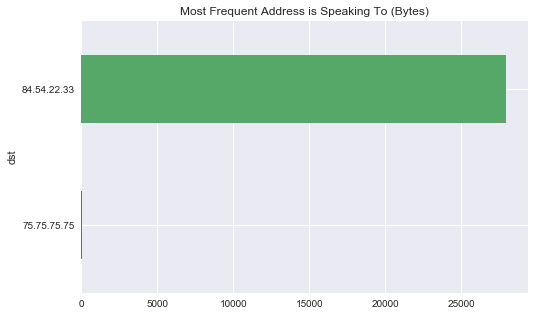

In [16]:
# Create dataframe with only converation from most frequent address
frequent_address_df = df[df['src']==frequent_address]

# Only display Src Address, Dst Address, and group by Payload 
frequent_address_groupby = frequent_address_df[['src','dst','payload']].groupby("dst")['payload'].sum()

# Plot the Frequent address is speaking to (By Payload)
frequent_address_groupby.plot(kind='barh',title="Most Frequent Address is Speaking To (Bytes)",figsize=(8,5))

# Which address has exchanged the most amount of bytes with most frequent address
suspicious_ip = frequent_address_groupby.sort_values(ascending=False).index[0]
print(suspicious_ip, "May be a suspicious address")

# Create dataframe with only conversation from most frequent address and suspicious address
suspicious_df = frequent_address_df[frequent_address_df['dst']==suspicious_ip]

In [17]:
# Store each payload in an array
raw_stream = []
for p in suspicious_df['payload_raw']:
    raw_stream.append(p)
    
print(raw_stream)

['\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbdPNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01b\x00\x00\x00\xef\xbf\xbd\x08\x06\x00\x00\x00(\xef\xbf\xbdTR\x00\x00:\xef\xbf\xbdIDATx\xef\xbf\xbd\xef\xbf\xbd\t|T\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd;K\x12\x08;\x08\xef\xbf\xbd\nE\xef\xbf\xbd\xef\xbf\xbd$\x19\xef\xbf\xbd\xef\xbf\xbdZi\xdf\xaa-\xef\xbf\xbd;N2\xef\xbf\xbd\xef\xbf\xbdV\xef\xbf\xbdV\xef\xbf\xbda\xef\xbf\xbdZ\x11!\xef\xbf\xbd\xef\xbf\xbd\x01\xdc\xbbik[\xef\xbf\xbd.ok\xef\xbf\xbde\xef\xbf\xbd\x01\\\xef\xbf\xbd\xef\xbf\xbd]\xef\xbf\xbd-\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdd\xef\xbf\xbd\x08\xef\xbf\xbd\x08\xef\xbf\xbd\xef\xbf\xbdg\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd<\xef\xbf\xbd\xef\xbf\xbdL\x12\xef\xbf\xbd$3wf\xef\xbf\xbd\xef\xbf\xbd\x02<_\r\xef\xbf\xbdY\xef\xbf\xbdr\xef\xbf\xbd\xef\xbf\xbdy\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x1c\r\x18\xef\xbf\xbd8c\xef\xbf\xbdew\r\x1e\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf